## Imports

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Helper functions

In [2]:
def plot_fig(figsize: tuple[int, int], rows: int, cols: int, data_list: tuple, title_list: tuple[str], plot_type_list: tuple[str], autoscale=tuple[bool]) -> None:
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        for i in range(cols):
            if plot_type_list[i] == 'imshow':
                if autoscale[i]:
                    ax[i].imshow(X=data_list[i], cmap='gray')
                else:
                    ax[i].imshow(X=data_list[i], cmap='gray', vmin=0, vmax=255)
            elif plot_type_list[i] == 'hist':
                ax[i].hist(data_list[i].ravel(), bins=256, range=[0,256])
            elif plot_type_list[i] == 'plot':
                ax[i].plot(data_list[i])
            ax[i].set_title(title_list[i])
    else:
        for i in range(rows):
            for j in range(cols):
                if i*cols+j+1 > len(data_list):
                    break

                if plot_type_list[i*cols+j] == 'imshow':
                    if autoscale[i*cols+j]:
                        ax[i, j].imshow(X=data_list[i*cols+j], cmap='gray')
                    else:
                        ax[i, j].imshow(X=data_list[i*cols+j], cmap='gray', vmin=0, vmax=255)
                elif plot_type_list[i*cols+j] == 'hist':
                    ax[i, j].hist(data_list[i*cols+j].ravel(), bins=256, range=[0,256])
                elif plot_type_list[i*cols+j] == 'plot':
                    ax[i, j].plot(data_list[i*cols+j])
                ax[i, j].set_title(title_list[i*cols+j])
    plt.show()

## Question 1

In this problem, you will use your image processing knowledge to repair a corrupted image.  
Remove the lines and artifacts from the corrupted *“fruits.png”* image.

<img src="fruits.png" width="200" height="200"/>

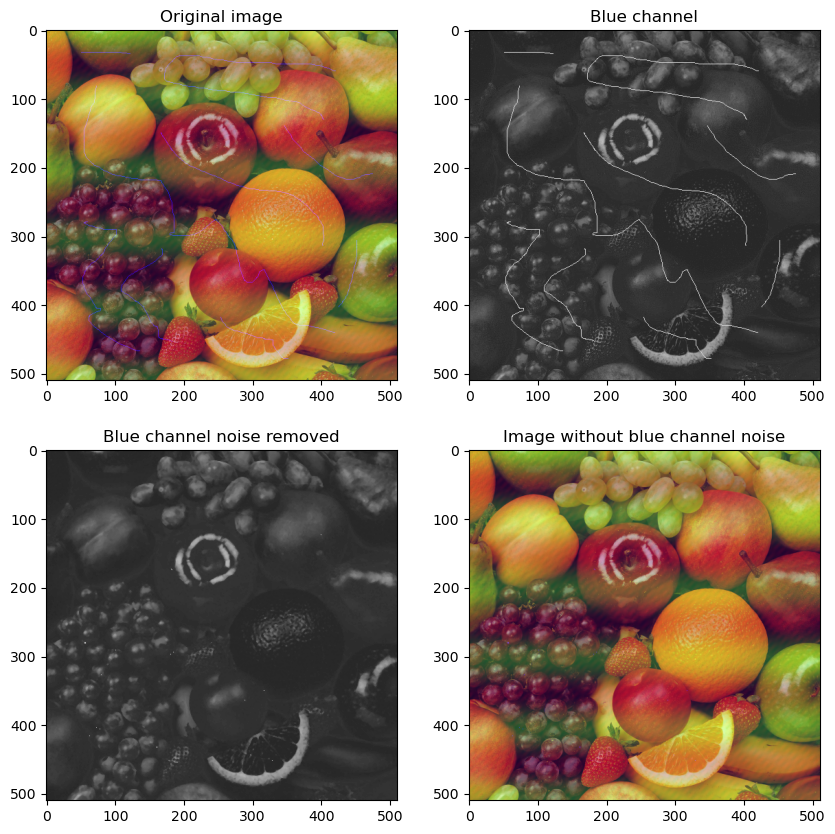

In [3]:
q1_image = cv2.cvtColor(cv2.imread('fruits.png'), cv2.COLOR_BGR2RGB)
blue_channel = q1_image[:, :, 2]
blue_channel_noise_removed = cv2.medianBlur(src=blue_channel, ksize=3)
image_without_blue_line_noise = np.concatenate((q1_image[:, :, :2], blue_channel_noise_removed.reshape(q1_image.shape[0], q1_image.shape[1], 1)), axis=2)
plot_fig(
    figsize=(10, 10), 
    rows=2, 
    cols=2, 
    data_list=(q1_image, blue_channel, blue_channel_noise_removed, image_without_blue_line_noise), 
    title_list=("Original image", "Blue channel", "Blue channel noise removed", "Image without blue channel noise"), 
    plot_type_list=("imshow",)*4, 
    autoscale=(False,)*4
)

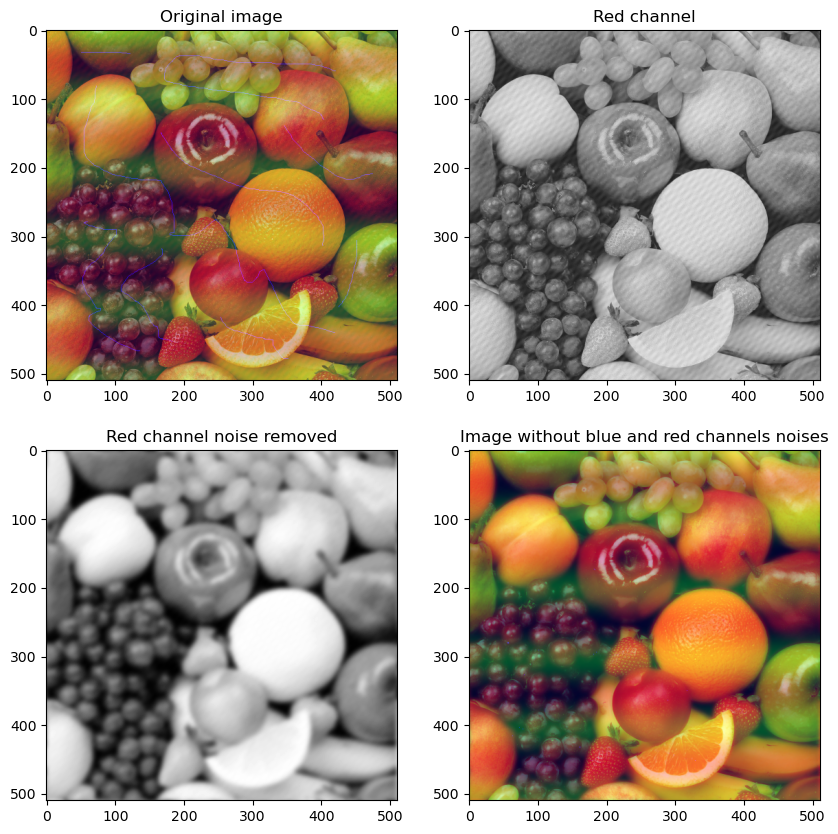

In [4]:
def fourier_transform(image: np.ndarray) -> tuple[np.ndarray]:
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)
    dft_magnitude_spectrum = np.log(np.abs(dft)+1)
    dft_shift_magnitude_spectrum = np.log(np.abs(dft_shift)+1)
    return dft, dft_shift, dft_magnitude_spectrum, dft_shift_magnitude_spectrum

def lowpass_filter(image: np.ndarray, d0: int, n: int, filter_type: str) -> tuple[np.ndarray]:
    dft, dft_shift, dft_magnitude_spectrum, dft_shift_magnitude_spectrum = fourier_transform(image=image)
    h = np.zeros(image.shape)
    center_x = image.shape[0] // 2
    center_y = image.shape[1] // 2
    if filter_type == 'butterworth':
        for i in range(h.shape[0]):
            for j in range(h.shape[1]):   
                h[i, j] = 1 / (1 + (np.sqrt((i-center_x)**2 + (j-center_y)**2) / d0)**(2*n))
    elif filter_type == 'gaussian':
        for i in range(h.shape[0]):
            for j in range(h.shape[1]): 
                h[i, j] = np.exp(-(((i-center_x)**2 + (j-center_y)**2) / (2*d0**2)))
    elif filter_type == 'ideal':
        for i in range(h.shape[0]):
            for j in range(h.shape[1]):
                h[i, j] = 1 if np.sqrt((i-center_x)**2 + (j-center_y)**2) <= d0 else 0
    dft_shift_filtered = dft_shift*h
    dft_shift_filtered_magnitude_spectrum = np.log(np.abs(dft_shift_filtered+1))
    final_image = np.abs(np.fft.ifft2(np.fft.ifftshift(dft_shift_filtered)))
    return dft_magnitude_spectrum, dft_shift_magnitude_spectrum, h, dft_shift_filtered_magnitude_spectrum, final_image

red_channel = image_without_blue_line_noise[:, :, 0]
red_channel_noise_removed = cv2.normalize(src=lowpass_filter(image=red_channel, d0=25, n=None, filter_type='gaussian')[-1], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
image_without_blue_line_and_periodic_noise = np.concatenate((red_channel_noise_removed.reshape(q1_image.shape[0], q1_image.shape[1], 1), image_without_blue_line_noise[:, :, 1:]), axis=2)
plot_fig(
    figsize=(10, 10), 
    rows=2, 
    cols=2, 
    data_list=(q1_image, red_channel, red_channel_noise_removed, image_without_blue_line_and_periodic_noise), 
    title_list=("Original image", "Red channel", "Red channel noise removed", "Image without blue and red channels noises"), 
    plot_type_list=("imshow",)*4, 
    autoscale=(False,)*4
)

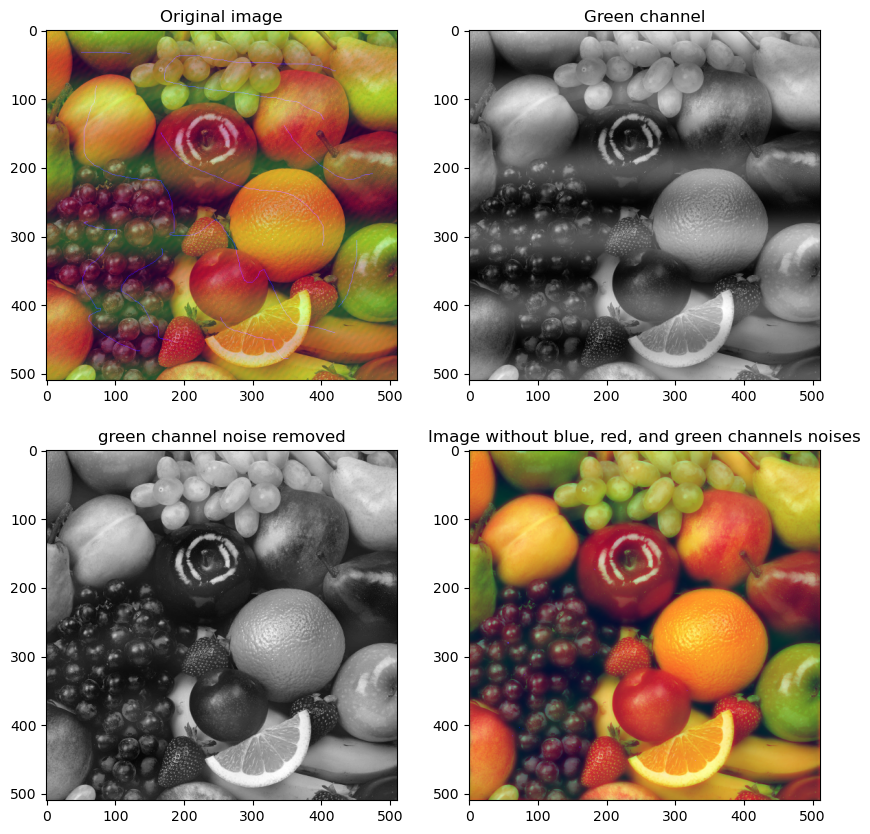

In [5]:
green_channel = image_without_blue_line_noise[:, :, 1]
q1_green_channel_dft_shift = fourier_transform(image=green_channel)[1]
h = np.zeros(q1_green_channel_dft_shift.shape)
center_x = h.shape[0]//2
center_y = h.shape[1]//2
for i in range(h.shape[0]):
    for j in range(h.shape[1]):
        h[i, j] = 0 if np.sqrt((i-center_x)**2 + (j-center_y)**2) == 5 else 1

# q1_green_channel_dft_shift[q1_green_dft_shift.shape[0]//2-5, q1_green_dft_shift.shape[1]//2] = 0
# q1_green_channel_dft_shift[q1_green_dft_shift.shape[0]//2+5, q1_green_dft_shift.shape[1]//2] = 0
# q1_green_channel_dft_shift[q1_green_dft_shift.shape[0]//2, q1_green_dft_shift.shape[1]//2-5] = 0
# q1_green_channel_dft_shift[q1_green_dft_shift.shape[0]//2, q1_green_dft_shift.shape[1]//2+5] = 0
# green_channel_noise_removed = cv2.normalize(src=np.abs(np.fft.ifft2(np.fft.ifftshift(q1_green_dft_shift))), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
green_channel_noise_removed = cv2.normalize(src=np.abs(np.fft.ifft2(np.fft.ifftshift(q1_green_channel_dft_shift*h))), dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
image_without_blue_line_and_periodic_and_halo_noise = np.concatenate((image_without_blue_line_and_periodic_noise[:, :, 0].reshape(image_without_blue_line_noise.shape[0], image_without_blue_line_noise.shape[1], 1), green_channel_noise_removed.reshape(image_without_blue_line_noise.shape[0], image_without_blue_line_and_periodic_noise.shape[1], 1), image_without_blue_line_noise[:, :, 2].reshape(image_without_blue_line_noise.shape[0], image_without_blue_line_noise.shape[1], 1)), axis=2)
plot_fig(
    figsize=(10, 10), 
    rows=2, 
    cols=2, 
    data_list=(q1_image, green_channel, green_channel_noise_removed, image_without_blue_line_and_periodic_and_halo_noise), 
    title_list=("Original image", "Green channel", "green channel noise removed", "Image without blue, red, and green channels noises"), 
    plot_type_list=("imshow",)*4, 
    autoscale=(True,)*4
)

## Question 2

Apply histogram equalization to tune the low-exposure image *“badexposure.jpg”*.  
Show the histograms before and after applying the histogram equalization algorithm.

<img src="badexposure.jpg" width="200" height="200"/>

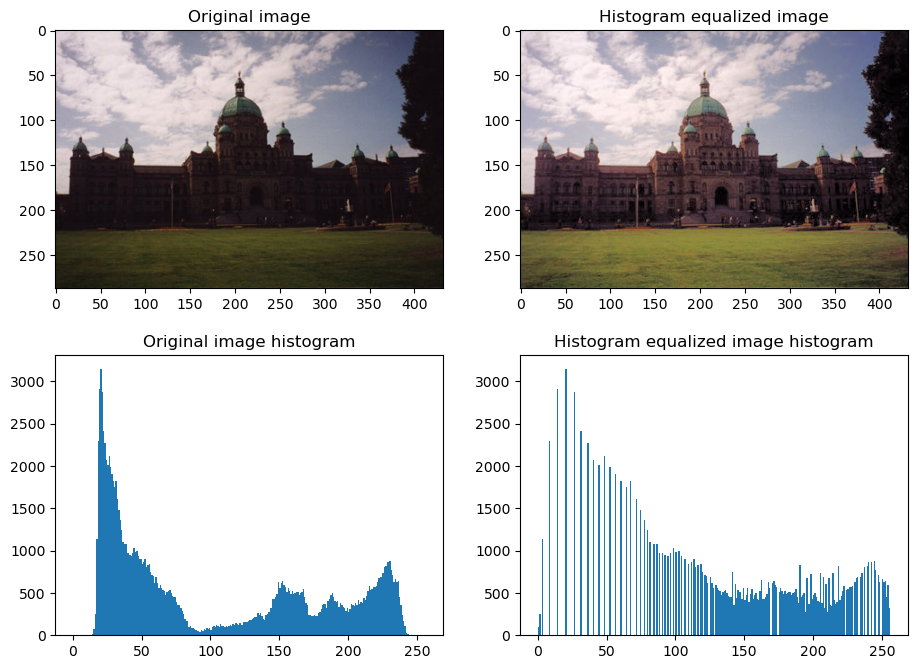

In [6]:
q2_image_hsv = cv2.cvtColor(cv2.imread('badexposure.jpg'), cv2.COLOR_BGR2HSV)
q2_image_rgb = cv2.cvtColor(q2_image_hsv, cv2.COLOR_HSV2RGB)
q2_image_equalized_hsv = np.concatenate((q2_image_hsv[:, :, :2], cv2.equalizeHist(q2_image_hsv[:, :, 2]).reshape(q2_image_hsv.shape[0], q2_image_hsv.shape[1], 1)), axis=2)
q2_image_equalized_rgb = cv2.cvtColor(q2_image_equalized_hsv, cv2.COLOR_HSV2RGB)

plot_fig(
    figsize=(11, 8), 
    rows=2, 
    cols=2, 
    data_list=(q2_image_rgb, q2_image_equalized_rgb, q2_image_hsv[:, :, 2], q2_image_equalized_hsv[:, :, 2]), 
    title_list=("Original image", "Histogram equalized image", "Original image histogram", "Histogram equalized image histogram"), 
    plot_type_list=("imshow", "imshow", "hist", "hist"), 
    autoscale=(False,)*4
)

## Question 3

**A)** Remove the noise from the image *“splash.png*.    
**B)** Separate the two types of blobs in the *“blobs.png”*.


<div style="display: flex;">
    <img src="splash.png" alt="Image 1" width="200" height="200"/>
    <img src="blobs.png" alt="Image 2" width="200" height="200"/>
</div>


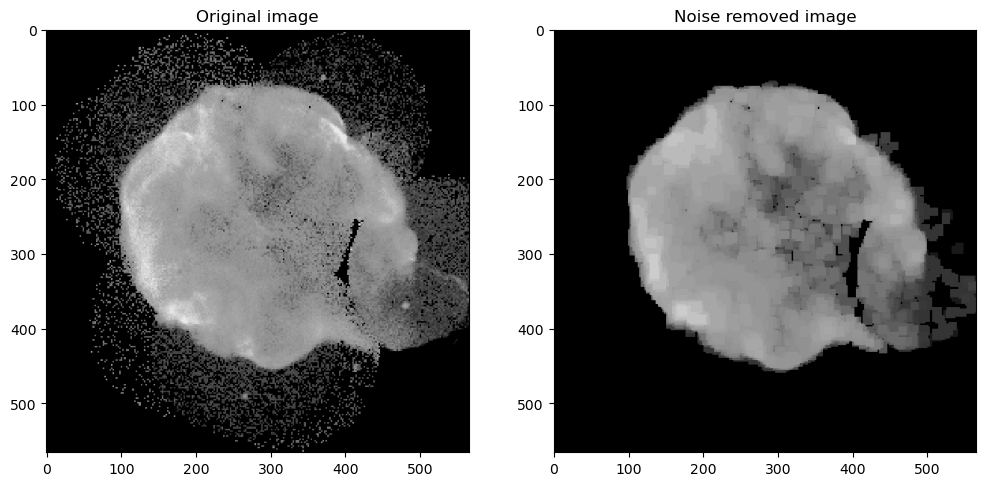

In [7]:
q3a_image = cv2.imread('splash.png', flags=cv2.IMREAD_GRAYSCALE)
q3a_structuring_element1 = np.ones((10, 10))
q3a_opening = cv2.morphologyEx(src=q3a_image, op=cv2.MORPH_OPEN, kernel=q3a_structuring_element1)

plot_fig(
    figsize=(12, 15), 
    rows=1, 
    cols=2, 
    data_list=(q3a_image, q3a_opening), 
    title_list=("Original image", "Noise removed image"), 
    plot_type_list=("imshow", "imshow"), 
    autoscale=(False,)*2
)

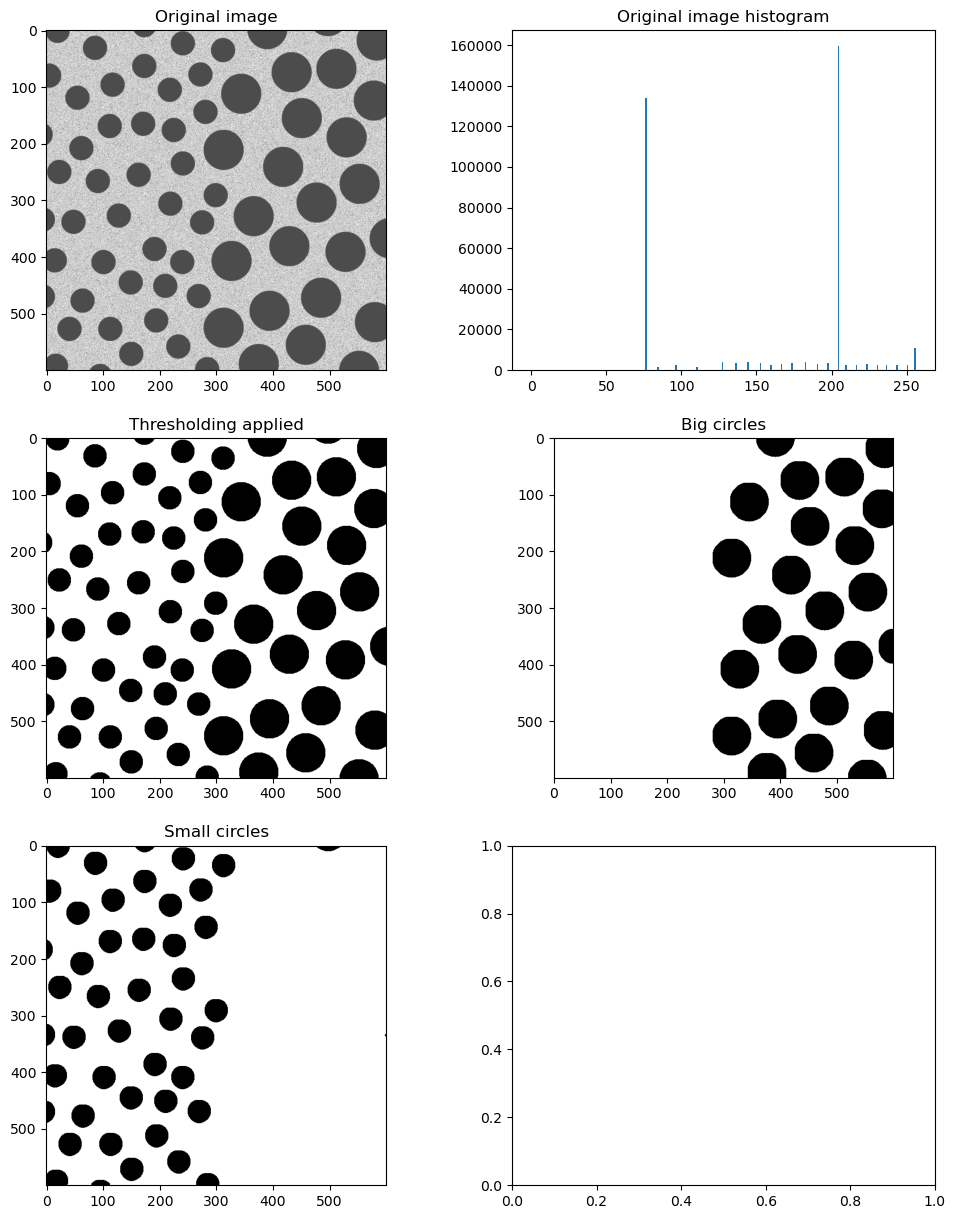

In [8]:
q3b_image = cv2.imread('blobs.png', flags=cv2.IMREAD_GRAYSCALE)
q3b_image_thresholding_applied = q3b_image.copy()
q3b_image_thresholding_applied[q3b_image_thresholding_applied <= q3b_image.min()] = 0
q3b_image_thresholding_applied[q3b_image_thresholding_applied > q3b_image.min()] = 255
q3b_structuring_element1 = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(50, 50))
q3b_image_big_circles = cv2.morphologyEx(src=q3b_image_thresholding_applied, op=cv2.MORPH_CLOSE, kernel=q3b_structuring_element1)
q3b_structuring_element2 = cv2.getStructuringElement(shape=cv2.MORPH_ELLIPSE, ksize=(4, 4))
q3b_image_small_circles = cv2.morphologyEx(src=q3b_image_thresholding_applied - np.abs(q3b_image_big_circles - 255), op=cv2.MORPH_CLOSE, kernel=q3b_structuring_element2)

plot_fig(
    figsize=(12, 15), 
    rows=3, 
    cols=2, 
    data_list=(q3b_image, q3b_image, q3b_image_thresholding_applied, q3b_image_big_circles, q3b_image_small_circles), 
    title_list=("Original image", "Original image histogram", "Thresholding applied", "Big circles", "Small circles"), 
    plot_type_list=("imshow", "hist", "imshow", "imshow", "imshow"), 
    autoscale=(False,)*5
)

## Question 4

The image *“rices.png”* includes objects of rice grains of different orientations over a dark background.     
In this problem, you are asked to develop a program to:     

**A)** Detect (extract from the background) the rice grain objects (By example, using thresholding)     
**B)** Compute the number and average size of the rice grains. (Use the morphological operations to count the number of rice grains, such as Opening, Closing connected components, and …)


<img src="rices.png" width="200" height="200"/>

Number of detected rice grain objects: 75
Mean area of rice grain objects: 1439.58


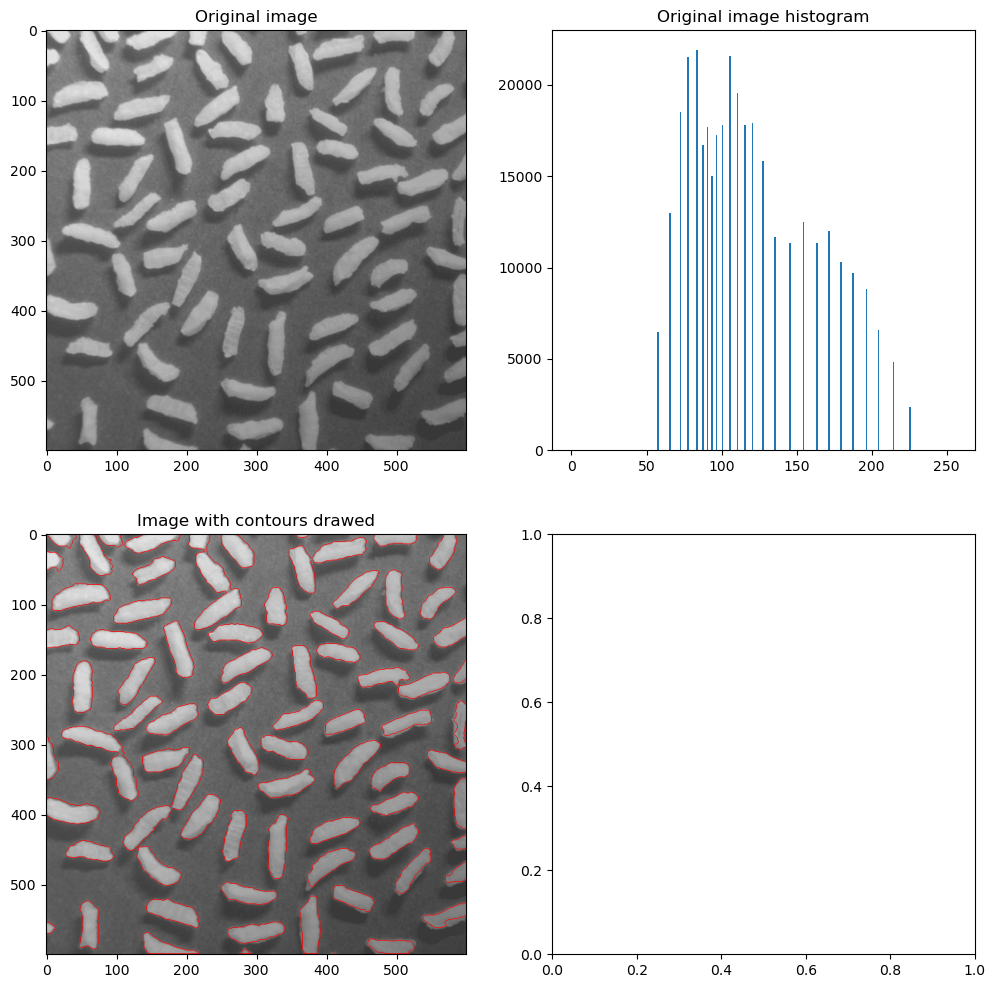

In [9]:
q4_image = cv2.imread('rices.png', flags=cv2.IMREAD_GRAYSCALE)

q4_threshold1 = q4_image.copy()[:q4_image.shape[0]//2, :]
q4_threshold1[q4_threshold1 <= 140] = 0
q4_threshold1[q4_threshold1 > 140] = 255
q4_threshold1 = np.abs(255 - q4_threshold1)
q4_threshold1 = cv2.erode(src=q4_threshold1, kernel=np.ones((1, 4)))
q4_threshold1 = np.abs(255 - q4_threshold1)

q4_threshold2 = q4_image.copy()[q4_image.shape[0]//2:, :]
q4_threshold2[q4_threshold2 <= 115] = 0
q4_threshold2[q4_threshold2 > 115] = 255
q4_threshold2 = np.abs(255 - q4_threshold2)
q4_threshold2 = cv2.erode(src=q4_threshold2, kernel=np.ones((1, 4)))
q4_threshold2 = np.abs(255 - q4_threshold2)

q4_threshold_applied = np.concatenate((q4_threshold1, q4_threshold2), axis=0)
q4_threshold_applied = cv2.medianBlur(src=q4_threshold_applied, ksize=5)

q4_contours = cv2.findContours(q4_threshold_applied, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
q4_output_contour = cv2.cvtColor(q4_image, cv2.COLOR_GRAY2RGB)
cv2.drawContours(image=q4_output_contour, contours=q4_contours, contourIdx=-1, color=(255, 0, 0), thickness=1)

q4_area_mean = np.mean([cv2.contourArea(contour) for contour in q4_contours])
print(f"Number of detected rice grain objects: {len(q4_contours)}")
print(f"Mean area of rice grain objects: {q4_area_mean}")

plot_fig(
    figsize=(12, 12), 
    rows=2, 
    cols=2, 
    data_list=(q4_image, q4_image, q4_output_contour), 
    title_list=("Original image", "Original image histogram", "Image with contours drawed"), 
    plot_type_list=("imshow", "hist", "imshow"), 
    autoscale=(False,)*3
)